<a href="https://www.kaggle.com/code/georgemorales/medical-cost-notebook?scriptVersionId=92990642" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


Objective:
- identify the signifacnt features in predicting medical cost
- predict medical cost as accurately as possible

This will be a supervised regression problem. Using RMSE as the performance metric.

In [2]:
df = pd.read_csv("/kaggle/input/insurance/insurance.csv")

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


There are no missing values

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


since no test set is provided we have to sample a test set from the dataframe.

In [6]:
# stratified sampling using 'sex' as strata
from sklearn.model_selection import StratifiedShuffleSplit
sampler = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sampler.split(df, df['sex']):
    train = df.loc[train_index]
    test = df.loc[test_index]

In [7]:
train.shape

(1070, 7)

In [8]:
test.shape

(268, 7)

# EDA

In [9]:
# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
train.head()

,age,sex,bmi,children,smoker,region,charges
242,55,female,26.80,1,no,southwest,35160.13457
1157,23,female,23.18,2,no,northwest,14426.07385
944,62,male,39.93,0,no,southeast,12982.87470
864,51,male,25.40,0,no,southwest,8782.46900
342,60,female,27.55,0,no,northeast,13217.09450


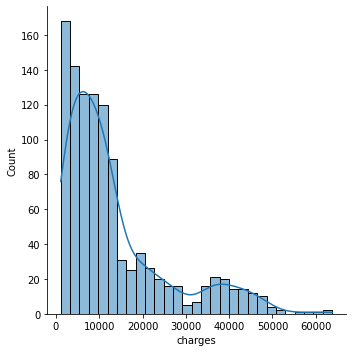

In [11]:
# Distribution of the response
sns.displot(x='charges', data = train, kde = True)

`charges` is right skewed

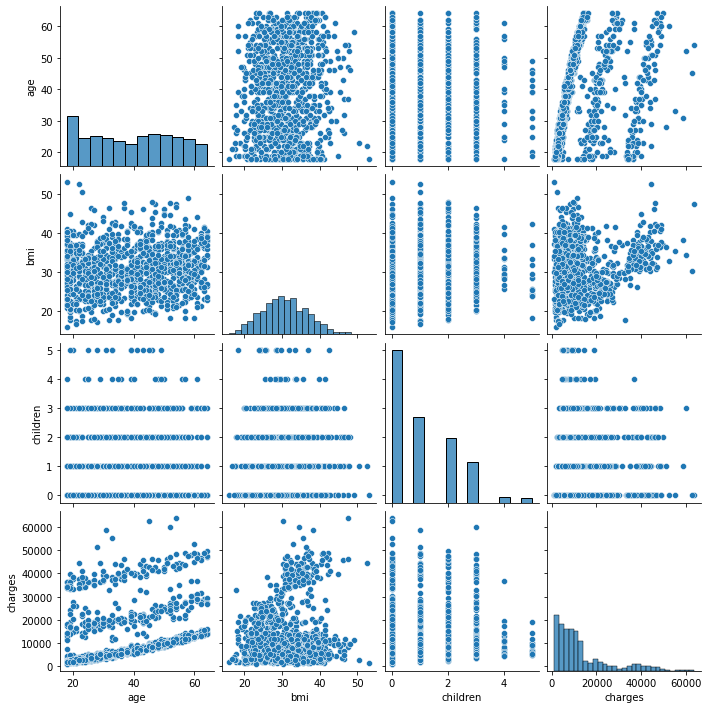

In [12]:
sns.pairplot(train)

- There seems to be a pattern between `charges` and `age` as well as `charges` and `bmi`.
- `age` is uniformly distributed
- `charges` is right skewed

<AxesSubplot:xlabel='age', ylabel='charges'>

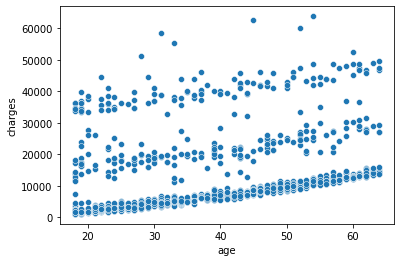

In [13]:
sns.scatterplot(x = 'age', y = 'charges', data = train)

We can observe three linear patterns here. 

Let's try separating the points using the categorical variables

<AxesSubplot:xlabel='age', ylabel='charges'>

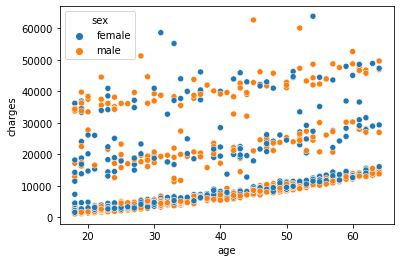

In [14]:
sns.scatterplot(x = 'age', y = 'charges', data = train, hue = 'sex')

<AxesSubplot:xlabel='age', ylabel='charges'>

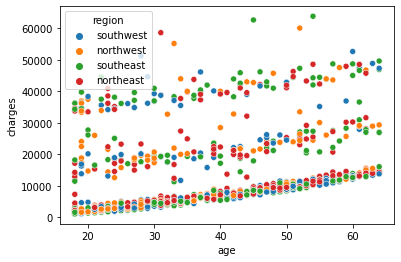

In [15]:
sns.scatterplot(x = 'age', y = 'charges', data = train, hue = 'region')

<AxesSubplot:xlabel='age', ylabel='charges'>

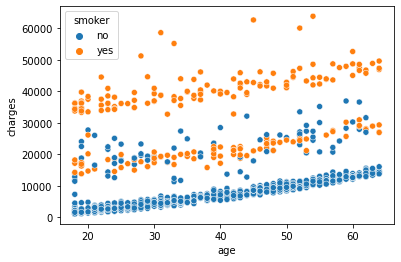

In [16]:
sns.scatterplot(x = 'age', y = 'charges', data = train, hue = 'smoker')

Smokers and non-smokers are dividing the linear patterns almost perfectly. Non-smokers tend to have less charges, and smokers tend to have larger charges. Then there is the line in the middle with a mix of both.

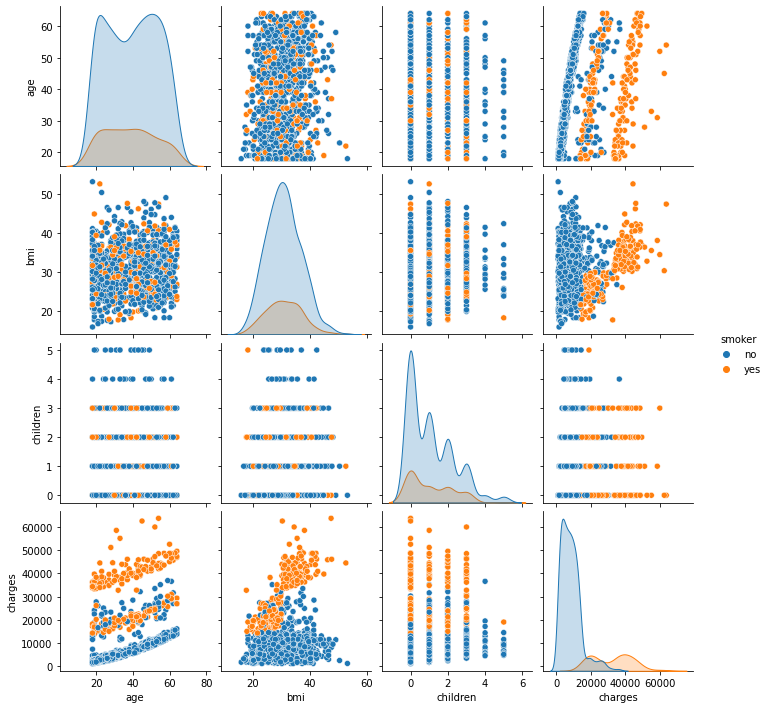

In [17]:
sns.pairplot(train, hue = 'smoker')

A  clear division between smokers and non-smokers can also be seen between `charges` and `bmi`.

<AxesSubplot:xlabel='charges'>

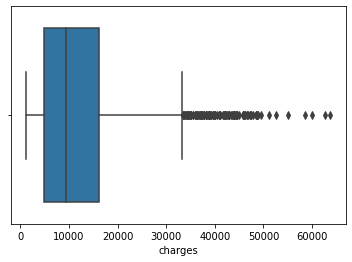

In [18]:
# outliers in the label
sns.boxplot(x='charges', data=train)

In [19]:
from scipy import stats
def outlier_remover(x, strategy = 'ignore', factor = None):
    if strategy == 'ignore':
        return
    elif strategy == 'iqr':
        outliers = iqr_outlier(y, factor = factor)
    elif strategy == 'std':
        outliers = std_outlier(y, factor = factor)
    elif strategy =='z_score':
        outliers = zscore_outlier(y, factor = factor)
    return X[outliers == 0], y[outliers == 0]

def iqr_outlier(x, factor = 1.5):
    if factor is None:
        factor = 1.5
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    min_ = q1 - factor * iqr
    max_ = q3 + factor * iqr
    result = pd.Series([0] * len(x), index = x.index)
    result[((x < min_) | (x > max_))] = 1
    return result

def std_outlier(x, factor = 2):
    if factor is None:
        factor = 2
    std = x.std()
    mean = x.mean()
    min_ = mean - factor * std
    max_ = mean + factor * std
    result = pd.Series([0] * len(x), index = x.index)
    result[((x < min_ ) | (x > max_))] = 1
    return result

def zscore_outlier(x, factor = 3):
    if factor is None:
        factor = 3
    x = stats.zscore(x)
    result = pd.Series([0] * len(x), index=x.index)
    result[((x < -factor ) | (x > factor))] = 1
    return result

In [20]:
outliers_iqr = iqr_outlier(train['charges'])
outliers_std = std_outlier(train['charges'])
outliers_z = zscore_outlier(train['charges'])

In [21]:
print('iqr outliers: ', outliers_iqr.sum())
print('std outliers: ', outliers_std.sum())
print('z-score outliers: ', outliers_z.sum())

iqr outliers:  120
std outliers:  85
z-score outliers:  8


There are outliers in the label but their values are not due to measurement error and there is no specific reason to remove them. So we will leave it (although this will definitely reduce the power of the model)

<AxesSubplot:>

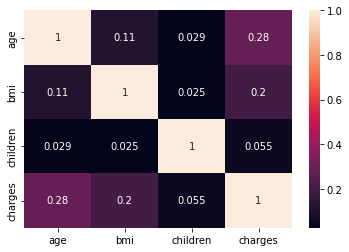

In [22]:
sns.heatmap(train.corr(), annot=True)

# References
- https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmi_dis.htm
- https://priscilla-vanny.medium.com/linear-regression-with-k-fold-cross-validation-in-python-predict-the-health-insurance-cost-7badf90fc1b8
- https://statisticsbyjim.com/basics/remove-outliers/
- https://towardsdatascience.com/outlier-detection-methods-in-machine-learning-1c8b7cca6cb8

# Preprocessing

first pass (before making a model)

In [23]:
predictors = train.drop('charges', axis = 1)
label = train['charges'].copy()

In [24]:
cat_feat = list(predictors.select_dtypes(include='object').columns)
num_feat = list(predictors.select_dtypes(include='number'))

In [25]:
cat_feat

['sex', 'smoker', 'region']

In [26]:
num_feat

['age', 'bmi', 'children']

categorize bmi according to weight ang obesity. [National Heart, Lung, and Blood Institute](https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmi_dis.htm) lists the categories for weight and obesity

In [27]:
def bmi_categorizer(x):
    if x < 18.5:
        return 1 #'underweight'
    elif x < 24.9:
        return 2 # normal
    elif x < 29.9:
        return 3 # overweight
    elif x < 34.9:
        return 4 # obesity I
    elif x < 39.9:
        return 5 # obesity II
    else:
        return 6 # extremely obesity
def add_features(x, add_bmi_category = True):
    x = x.copy()
    if add_bmi_category:
        x['bmi_category'] = x['bmi'].apply(bmi_categorizer)
        return x


In [28]:
predictors = add_features(predictors)

In [29]:
predictors

,age,sex,bmi,children,smoker,region,bmi_category
242,55,female,26.800,1,no,southwest,3
1157,23,female,23.180,2,no,northwest,2
944,62,male,39.930,0,no,southeast,6
864,51,male,25.400,0,no,southwest,3
342,60,female,27.550,0,no,northeast,3
...,...,...,...,...,...,...,...
651,53,female,39.600,1,no,southeast,5
594,41,male,40.260,0,no,southeast,6
641,42,male,28.310,3,yes,northwest,3
733,48,female,27.265,1,no,northeast,3


scaling numerical variables

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(predictors[num_feat])
predictors[num_feat] = scaler.transform(predictors[num_feat])

In [31]:
predictors

,age,sex,bmi,children,smoker,region,bmi_category
242,1.128292,female,-0.652942,-0.072616,no,southwest,3
1157,-1.175389,female,-1.243677,0.762857,no,northwest,2
944,1.632222,male,1.489698,-0.908089,no,southeast,6
864,0.840332,male,-0.881403,-0.908089,no,southwest,3
342,1.488242,female,-0.530552,-0.908089,no,northeast,3
...,...,...,...,...,...,...,...
651,0.984312,female,1.435847,-0.072616,no,southeast,5
594,0.120432,male,1.543550,-0.908089,no,southeast,6
641,0.192422,male,-0.406530,1.598331,yes,northwest,3
733,0.624362,female,-0.577060,-0.072616,no,northeast,3


encode categorical variables

In [32]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='if_binary', sparse=False)
encoder.fit(predictors[cat_feat])
predictors_1hot = encoder.transform(predictors[cat_feat])

In [33]:
encoder.get_feature_names_out(cat_feat).tolist()

['sex_male',
 'smoker_yes',
 'region_northeast',
 'region_northwest',
 'region_southeast',
 'region_southwest']

In [34]:
predictors[encoder.get_feature_names_out(cat_feat).tolist()] = predictors_1hot
predictors.drop(cat_feat, axis=1, inplace=True)

In [35]:
predictors

,age,bmi,children,bmi_category,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
242,1.128292,-0.652942,-0.072616,3,0.0,0.0,0.0,0.0,0.0,1.0
1157,-1.175389,-1.243677,0.762857,2,0.0,0.0,0.0,1.0,0.0,0.0
944,1.632222,1.489698,-0.908089,6,1.0,0.0,0.0,0.0,1.0,0.0
864,0.840332,-0.881403,-0.908089,3,1.0,0.0,0.0,0.0,0.0,1.0
342,1.488242,-0.530552,-0.908089,3,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
651,0.984312,1.435847,-0.072616,5,0.0,0.0,0.0,0.0,1.0,0.0
594,0.120432,1.543550,-0.908089,6,1.0,0.0,0.0,0.0,1.0,0.0
641,0.192422,-0.406530,1.598331,3,1.0,1.0,0.0,1.0,0.0,0.0
733,0.624362,-0.577060,-0.072616,3,0.0,0.0,1.0,0.0,0.0,0.0


In [36]:
exp_df = pd.concat([predictors, label], axis = 1)

<AxesSubplot:>

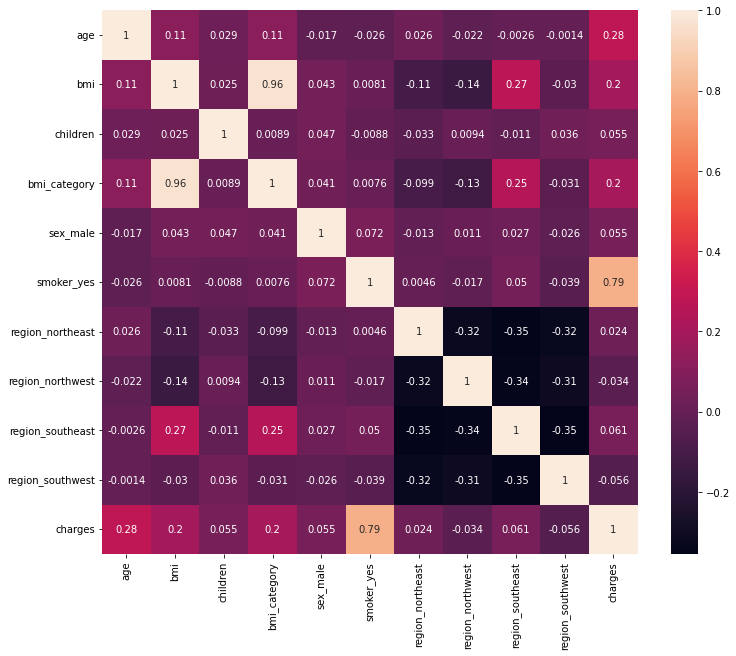

In [37]:
plt.figure(figsize=(12,10))
sns.heatmap(exp_df.corr(), annot=True)

- `smoker_yes`, `age`, and `bmi` are the top three correlated features to `charges`.
- `bmi` and `bmi_category` is redundant. we need to remove `bmi`. 
https://stats.stackexchange.com/questions/230750/when-should-we-discretize-bin-continuous-independent-variables-features-and-when

In [38]:
# get index of bmi column
bmi_idx = predictors.columns.get_loc('bmi')
# make a function to remove bmi
def remove_bmi(x):
    return np.delete(x[:], bmi_idx, axis=1)

create a pipeline

In [39]:
cat_feat

['sex', 'smoker', 'region']

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

num_pipeline = Pipeline([
    ('feat_adder', FunctionTransformer(add_features, validate=False))
    , ('scaler', StandardScaler())
    , ('bmi_del', FunctionTransformer(remove_bmi, validate=False))
    
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse=False, drop='if_binary'))
])

preprocess_pipeline = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feat)
    , ('cat', cat_pipeline, cat_feat)
])

In [41]:
X = train.drop('charges', axis = 1)
y = train['charges'].copy()

In [42]:
X_processed = preprocess_pipeline.fit_transform(X)

In [43]:
X_processed[0]

array([ 1.12829229, -0.07261591, -0.57119156,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ])

In [44]:
predictors

,age,bmi,children,bmi_category,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
242,1.128292,-0.652942,-0.072616,3,0.0,0.0,0.0,0.0,0.0,1.0
1157,-1.175389,-1.243677,0.762857,2,0.0,0.0,0.0,1.0,0.0,0.0
944,1.632222,1.489698,-0.908089,6,1.0,0.0,0.0,0.0,1.0,0.0
864,0.840332,-0.881403,-0.908089,3,1.0,0.0,0.0,0.0,0.0,1.0
342,1.488242,-0.530552,-0.908089,3,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
651,0.984312,1.435847,-0.072616,5,0.0,0.0,0.0,0.0,1.0,0.0
594,0.120432,1.543550,-0.908089,6,1.0,0.0,0.0,0.0,1.0,0.0
641,0.192422,-0.406530,1.598331,3,1.0,1.0,0.0,1.0,0.0,0.0
733,0.624362,-0.577060,-0.072616,3,0.0,0.0,1.0,0.0,0.0,0.0


# Modeling

In [45]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_processed, y)

LinearRegression()

In [46]:
y_pred = lr.predict(X_processed)
y_pred

array([10650.63404981,  2318.20225786, 16870.88389549, ...,
       33227.94369512, 10061.74468974, 31444.46886677])

In [47]:
from sklearn.metrics import mean_squared_error
lr_mse = mean_squared_error(y, y_pred)
print(f'Root Mean Squared Error: {np.sqrt(lr_mse)}')

Root Mean Squared Error: 6049.374190980692


short-list models using cross-validation

In [48]:
# linear regression
from sklearn.model_selection import cross_val_score
lr_scores = cross_val_score(LinearRegression(), X_processed, y, scoring = 'neg_root_mean_squared_error', cv = 10)
lr_rmse = abs(lr_scores) 

In [49]:
def display_rmse(scores):
    print('Scores: ', scores)
    print('Mean RMSE:', scores.mean())
    print('Standard deviation: ', scores.std())

In [50]:
display_rmse(lr_rmse)

Scores:  [6303.34270298 5886.17431604 5730.69225472 6408.48914022 7181.57274073
 5653.75317686 6196.87135476 6276.4741728  5695.18113035 5360.59544274]
Mean RMSE: 6069.314643219833
Standard deviation:  492.87604499810493


In [51]:
# decision tree
from sklearn.tree import DecisionTreeRegressor
dt_scores = cross_val_score(DecisionTreeRegressor(), X_processed, y, scoring = 'neg_root_mean_squared_error', cv = 10)
dt_rmse = abs(dt_scores)

In [52]:
display_rmse(dt_rmse)

Scores:  [7015.3998156  7658.12500618 5167.7027026  6465.26613056 7007.58736331
 6301.64793972 6144.80943298 6405.73028513 4818.06397872 5757.16032618]
Mean RMSE: 6274.14929809716
Standard deviation:  817.6663613375159


In [53]:
from sklearn.ensemble import RandomForestRegressor
rf_scores = cross_val_score(RandomForestRegressor(), X_processed, y, scoring = 'neg_root_mean_squared_error', cv = 10)
rf_rmse = abs(rf_scores)

In [54]:
display_rmse(rf_rmse)

Scores:  [5451.3522723  4878.98752217 4613.55964554 5281.3610773  5954.44839044
 4791.42717907 4803.61158353 5275.18215311 4365.769834   4741.95160261]
Mean RMSE: 5015.765126006958
Standard deviation:  445.1946274296177


In [55]:
from sklearn.svm import SVR
svr_scores = cross_val_score(SVR(), X_processed, y, scoring = 'neg_root_mean_squared_error', cv = 10)
svr_rmse = abs(svr_scores)

In [56]:
display_rmse(svr_rmse)

Scores:  [11810.1618855  13832.60118868 11923.75761289 11402.13723705
 12868.66903932 13833.40942479 12863.93228164 13824.27819841
 11782.24644985 12437.64520295]
Mean RMSE: 12657.883852106334
Standard deviation:  886.5045214893807


In [57]:
from sklearn.neighbors import KNeighborsRegressor
kn_scores = cross_val_score(KNeighborsRegressor(), X_processed, y, scoring = 'neg_root_mean_squared_error', cv = 10)
kn_rmse = abs(kn_scores)

In [58]:
display_rmse(kn_rmse)

Scores:  [6420.1937136  7235.72305839 6080.2385403  7644.73570407 7396.9579387
 7702.07329099 7356.88315953 6870.59544241 6645.59056355 6143.19345627]
Mean RMSE: 6949.618486782563
Standard deviation:  572.9153632286781


rank the tested models by mean rmse

In [59]:
models_list = [lr_rmse, dt_rmse, rf_rmse, svr_rmse, kn_rmse]
models = { 'mean_rmse': [np.mean(model) for model in models_list]
         , 'std': [np.std(model) for model in models_list]
         }
models_df = pd.DataFrame(models, index = ['Linear Regression', 'Decision Tree', 'Random Forest', 'SVR', 'KNN'])

In [60]:
models_df.sort_values(by='mean_rmse')

,mean_rmse,std
Random Forest,5015.765126,445.194627
Linear Regression,6069.314643,492.876045
Decision Tree,6274.149298,817.666361
KNN,6949.618487,572.915363
SVR,12657.883852,886.504521


let's see what the most significant variables are for the top two models, Random Forest and Linear Regression.

In [61]:
# random forest
rf = RandomForestRegressor()
rf.fit(X_processed, y)
rf_feat_importances = rf.feature_importances_

In [62]:
num_attribs = ['age', 'children'] # bmi is dropped
extra_attribs = ["bmi_category"]
# get the encoder
cat_encoder = preprocess_pipeline.named_transformers_["cat"]
# get the categories made by the encoder
cat_1hot_attribs = cat_encoder.get_feature_names_out(cat_feat).tolist()
attributes = num_attribs + extra_attribs + cat_1hot_attribs
feat_importances_df = pd.DataFrame(rf_feat_importances, index = attributes, columns=['feature_importance']) 
feat_importances_df.sort_values(by = 'feature_importance', ascending = False)


,feature_importance
smoker_yes,0.632857
bmi_category,0.157615
age,0.144207
children,0.027786
sex_male,0.011244
region_northwest,0.008090
region_northeast,0.006473
region_southeast,0.006257
region_southwest,0.005471


For Random Forest, `smoker_yes`, `bmi_category`, and `age` are the most signicant variables

In [63]:
# linear regression
# for linear regression, use forward selection to determine signifact variables
X_processed_df = pd.DataFrame(X_processed, columns = attributes, index = y.index)

In [64]:
X_processed_df

,age,children,bmi_category,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
242,1.128292,-0.072616,-0.571192,0.0,0.0,0.0,0.0,0.0,1.0
1157,-1.175389,0.762857,-1.409566,0.0,0.0,0.0,1.0,0.0,0.0
944,1.632222,-0.908089,1.943932,1.0,0.0,0.0,0.0,1.0,0.0
864,0.840332,-0.908089,-0.571192,1.0,0.0,0.0,0.0,0.0,1.0
342,1.488242,-0.908089,-0.571192,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
651,0.984312,-0.072616,1.105557,0.0,0.0,0.0,0.0,1.0,0.0
594,0.120432,-0.908089,1.943932,1.0,0.0,0.0,0.0,1.0,0.0
641,0.192422,1.598331,-0.571192,1.0,1.0,0.0,1.0,0.0,0.0
733,0.624362,-0.072616,-0.571192,0.0,0.0,1.0,0.0,0.0,0.0


In [65]:
# Code reference - Feature selection: https://www.datasklr.com/ols-least-squares-regression/variable-selection
import statsmodels.api as sm

def forward_selection(X, y, threshold_in=0.01, verbose=True):
    include = []
    changed = True
    while changed:
        exclude = list(set(X.columns) - set(include))
        pvalues = pd.Series(index=list(X.columns), dtype=float)
        for column in exclude:
            model = sm.OLS(y, sm.add_constant(X[include + [column]])).fit()
            pvalues[column] = model.pvalues[column]
        best_pvalue = pvalues.min()
        if best_pvalue < threshold_in:
            include.append(pvalues.index[pvalues.argmin()])
            if verbose:
                print("Include: {0}\t p-value: {1}".format(pvalues.index[pvalues.argmin()], best_pvalue))
            continue
        changed = False
        
        return include

In [66]:
selected_features_fwd = forward_selection(X_processed_df, y)
print(f'forward: {selected_features_fwd}')

Include: smoker_yes	 p-value: 1.8825981339224108e-231
Include: age	 p-value: 8.42069609383203e-67
Include: bmi_category	 p-value: 1.2192724313251787e-24
Include: children	 p-value: 0.0006879943272428104
forward: ['smoker_yes', 'age', 'bmi_category', 'children']


For Linear Regression, `smoker_yes`, `bmi_category`, `age`, and `children` are the most signicant variables.

cross_validation using the important features

In [67]:
# Random forest
rf_selected_scores = cross_val_score(RandomForestRegressor(random_state = 42), X_processed_df[['smoker_yes','bmi_category','age']], y, scoring = 'neg_root_mean_squared_error', cv = 10)
rf_selected_rmse = abs(rf_selected_scores)

In [68]:
display_rmse(rf_selected_rmse)

Scores:  [5817.51354688 4721.99292181 5087.57162223 5576.77301597 6396.85897026
 4801.80748174 5100.63518481 5338.17773392 4806.49274548 4557.28029494]
Mean RMSE: 5220.510351802705
Standard deviation:  542.967471892888


In [69]:
# Linear Regression
lr_selected_scores = cross_val_score(LinearRegression(), X_processed_df[['smoker_yes','bmi_category','age']], y, scoring = 'neg_root_mean_squared_error', cv = 10)
lr_selected_rmse = abs(lr_selected_scores)

In [70]:
display_rmse(lr_selected_rmse)

Scores:  [6304.70284266 5947.23861892 5759.69499432 6449.42842547 7250.73290248
 5694.58198404 6184.72415523 6305.99403724 5686.56114748 5380.19511393]
Mean RMSE: 6096.385422176569
Standard deviation:  503.0137998307841


In [71]:
models_list = [rf_selected_rmse, lr_selected_rmse]
models = { 'mean_rmse': [np.mean(model) for model in models_list]
         , 'std': [np.std(model) for model in models_list]
         }
models_selected = pd.DataFrame(models, index = ['Random Forest Selected', 'Linear Regression Selected'])

In [72]:
models_selected

,mean_rmse,std
Random Forest Selected,5220.510352,542.967472
Linear Regression Selected,6096.385422,503.013800


In [73]:
models_df.append(models_selected).sort_values(by='mean_rmse')

,mean_rmse,std
Random Forest,5015.765126,445.194627
Random Forest Selected,5220.510352,542.967472
Linear Regression,6069.314643,492.876045
Linear Regression Selected,6096.385422,503.013800
Decision Tree,6274.149298,817.666361
KNN,6949.618487,572.915363
SVR,12657.883852,886.504521


# Hyperparameter tuning

In [74]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 500, 1000]
    , 'criterion': ['squared_error', 'absolute_error', 'poisson']
    , 'max_features': [3,4,5]
    , 'bootstrap': [True, False]
}

gridsearch_rf = GridSearchCV(RandomForestRegressor(random_state = 42), param_grid, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs=-1, verbose = 2)

In [75]:
gridsearch_rf.fit(X_processed, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['squared_error', 'absolute_error',
                                       'poisson'],
                         'max_features': [3, 4, 5],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [76]:
gridsearch_rf.best_estimator_

RandomForestRegressor(criterion='absolute_error', max_features=4,
                      n_estimators=1000, random_state=42)

In [77]:
abs(gridsearch_rf.best_score_)

4795.60846642222

In [78]:
rf_grid_scores = cross_val_score(gridsearch_rf.best_estimator_, X_processed, y, cv=10, scoring='neg_root_mean_squared_error')
rf_grid_rmse = abs(rf_grid_scores)

In [79]:
display_rmse(rf_grid_rmse)

Scores:  [5201.26944407 4235.63847602 4523.84632364 5219.58316694 5931.83360838
 4617.39563085 4521.28029399 4916.55709095 4304.4871326  4251.59959246]
Mean RMSE: 4772.349075989291
Standard deviation:  517.3126867630718


In [80]:
feature_importances = gridsearch_rf.best_estimator_.feature_importances_

In [81]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]



make full pipeline including the model

In [82]:
full_pipeline = Pipeline([
    ('preprocessor', preprocess_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k=4)) # k = 4, since best max_features = 4
    , ('model', gridsearch_rf.best_estimator_)
])

In [83]:
X_train = train.drop('charges', axis = 1)
y_train = train['charges'].copy()

last evaluation of the model

In [84]:
full_scores = cross_val_score(full_pipeline, X_train, y_train, cv = 10, scoring = 'neg_root_mean_squared_error')

In [85]:
display_rmse(abs(full_scores))

Scores:  [5964.19600746 4323.06449412 4853.95749219 5332.22902486 5920.7400277
 4729.68596423 4713.28007296 5272.70404215 4598.99943192 4514.99328756]
Mean RMSE: 5022.384984514547
Standard deviation:  546.6305825776053


test model on unseen data

In [86]:
X_test = test.drop('charges', axis = 1)
y_test = test['charges'].copy()

In [87]:
full_pipeline.fit(X_train, y_train) # fit on train data

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('feat_adder',
                                                                   FunctionTransformer(func=<function add_features at 0x7fe68e08ad40>)),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('bmi_del',
                                                                   FunctionTransformer(func=<function remove_bmi at 0x7fe68de2f8c0>))]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='if_binary',
 

In [88]:
y_pred = full_pipeline.predict(X_test) # predict test data

In [89]:
print(f'final rmse: {np.sqrt(mean_squared_error(y_test, y_pred))}')

final rmse: 5319.01669009367


# Conclusion
- smokers tend to have larger `charges` while non-smokers tend to have lower `charges`
- smoking is the most significant feature in determining `charges`
- `smoker`, `bmi`, `age` are the most correlated features to `charges`